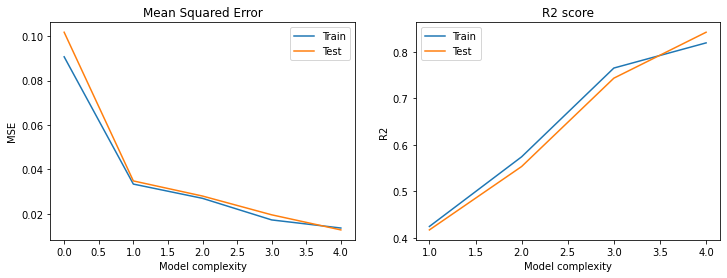

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2)) 
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

RANDOM_STATE = 42

n = 5   # Max order of polynomial
N = 50  # Number of points
noise = 0.1

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
x, y = np.meshgrid(x, y)

train_MSE = np.zeros(n)
test_MSE = np.zeros(n)
train_R2 = np.zeros(n)
test_R2 = np.zeros(n)

np.random.seed(RANDOM_STATE)

conf_intervals = np.zeros((n, 2))

for i in range(n):
    z = FrankeFunction(x, y)
    z += noise * np.random.randn(z.shape[0], z.shape[1])

    X = create_X(x, y, i)

    X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), random_state=RANDOM_STATE, test_size=0.3)

    linreg = LinearRegression()
    linreg.fit(X_train, z_train)

    z_tilde = linreg.predict(X_train)
    z_pred = linreg.predict(X_test)

    train_MSE[i] = mean_squared_error(z_tilde, z_train)
    train_R2[i] = r2_score(z_tilde, z_train)
    test_MSE[i] = mean_squared_error(z_pred, z_test)
    test_R2[i] = r2_score(z_pred, z_test)

    beta_mu = np.mean(linreg.coef_)
    beta_sigma = np.sqrt(np.var(linreg.coef_))
    num_betas = linreg.coef_.shape[0]
    z = 1.96

    conf_intervals[i, 0] = (beta_mu - (z * beta_sigma) / np.sqrt(num_betas))
    conf_intervals[i, 1] = (beta_mu + (z * beta_sigma) / np.sqrt(num_betas))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Mean Squared Error')
ax1.plot(range(n), train_MSE, label='Train')
ax1.plot(range(n), test_MSE, label='Test')
ax1.set_xlabel('Model complexity')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.set_title('R2 score')
ax2.plot(range(1, n), train_R2[1:], label='Train')
ax2.plot(range(1, n), test_R2[1:], label='Test')
ax2.set_xlabel('Model complexity')
ax2.set_ylabel('R2')
ax2.legend()

fig.set_figwidth(12)

In [7]:
import pandas as pd

intervals = pd.DataFrame(conf_intervals)
intervals.columns = ['lower', 'upper']

print('95% confidence interval:')
intervals

95% confidence interval:


,lower,upper
0,0.000000,0.000000
1,-0.929769,0.162690
2,-1.258758,0.875925
3,-5.362282,5.213538
4,-19.569295,19.464429
